#### Sort a list of elements

The purpose of the notebook is to train graph network to learn to sort a list of elements.



In [1]:
import time


from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos_tf2 import models
import matplotlib.pyplot as plt
import numpy as np

import sonnet as snt
import tensorflow as tf



SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# tf.argsort()

# argsort tells in what order to select elements from the array to get a sorted result
values = [1, 10, 26.9, 2.8, 166.32, 62.3]
sort_order = tf.argsort(values)
#print(sort_order)
#[0 3 1 2 5 4]
# which means take the element in position 0 (1)
# then take the one in position 3 (2.8)
# then take the one in position 1 (10)

In [75]:
def create_graph_dicts_tf(num_examples, num_elements_min_max):
  """Generate graphs for training.

  Args:
    num_examples: total number of graphs to generate
    num_elements_min_max: a 2-tuple with the minimum and maximum number of
      values allowable in a graph. The number of values for a graph is
      uniformly sampled withing this range. The upper bound is exclusive, and
      should be at least 2 more than the lower bound.

  Returns:
    inputs: contains the generated random numbers as node values.
    sort_indices: contains the sorting indices as nodes. Concretely
      inputs.nodes[sort_indices.nodes] will be a sorted array.
    ranks: the rank of each value in inputs normalized to the range [0, 1].
  """
  num_elements = tf.random.uniform(
      [num_examples],
      minval=num_elements_min_max[0],
      maxval=num_elements_min_max[1],
      dtype=tf.int32)
  inputs_graphs = []
  sort_indices_graphs = []
  ranks_graphs = []
  for i in range(num_examples):
    values = tf.random.uniform(shape=[num_elements[i]])#generate random features for each node of the graph
    sort_indices = tf.cast(
        tf.argsort(values, axis=-1), tf.float32)
    ranks = tf.cast(
        tf.argsort(sort_indices, axis=-1), tf.float32) / (
            tf.cast(num_elements[i], tf.float32) - 1.0)
    inputs_graphs.append({"nodes": values[:, None]})
    sort_indices_graphs.append({"nodes": sort_indices[:, None]})
    ranks_graphs.append({"nodes": ranks[:, None]})
  return inputs_graphs, sort_indices_graphs, ranks_graphs

In [76]:
graphs, indices, ranks =create_graph_dicts_tf(3,(3,8))
print(f'The number of graphs creates is : {len(graphs)}')
print(f'type {type(graphs)}')
print(f'type element {type(graphs[0])}')
print(f'the first graph is {graphs[0]["nodes"]}')
print(f'the sorted indices are {indices[0]["nodes"]}')

The number of graphs creates is : 3
type <class 'list'>
type element <class 'dict'>
the first graph is [[0.95214367]
 [0.7892797 ]
 [0.3518337 ]
 [0.04095459]
 [0.61420333]
 [0.8480252 ]]
the sorted indices are [[3.]
 [2.]
 [4.]
 [1.]
 [5.]
 [0.]]


In [80]:
def create_linked_list_target(batch_size, input_graphs):
  """Creates linked list targets.

  Returns a graph with the same number of nodes as `input_graph`. Each node
  contains a 2d vector with targets for a 1-class classification where only one
  node is `True`, the smallest value in the array. The vector contains two
  values: [prob_true, prob_false].
  It also contains edges connecting all nodes. These are again 2d vectors with
  softmax targets [prob_true, prob_false]. An edge is True
  if n+1 is the element immediately after n in the sorted list.

  Args:
    batch_size: batch size for the `input_graphs`.
    input_graphs: a `graphs.GraphsTuple` which contains a batch of inputs.

  Returns:
    A `graphs.GraphsTuple` with the targets, which encode the linked list.
  """
  target_graphs = []
  for i in range(batch_size):
    input_graph = utils_tf.get_graph(input_graphs, i)
    num_elements = tf.shape(input_graph.nodes)[0]
    si = tf.cast(tf.squeeze(input_graph.nodes), tf.int32)
    nodes = tf.reshape(tf.one_hot(si[:1], num_elements), (-1, 1))
    x = tf.stack((si[:-1], si[1:]))[None]
    y = tf.stack(
        (input_graph.senders, input_graph.receivers), axis=1)[:, :, None]
    edges = tf.reshape(
        tf.cast(
            tf.reduce_any(tf.reduce_all(tf.equal(x, y), axis=1), axis=1),
            tf.float32), (-1, 1))
    target_graphs.append(input_graph._replace(nodes=nodes, edges=edges))
  return utils_tf.concat(target_graphs, axis=0)

In [106]:
## graphs having only nodes
inputs, sort_indices, ranks = create_graph_dicts_tf(
      1, (3,8)) 

## transform disctionary in graphs tuple
inputs = utils_tf.data_dicts_to_graphs_tuple(inputs)
sort_indices = utils_tf.data_dicts_to_graphs_tuple(sort_indices)

## add edges for create a fully connected graph
inputs = utils_tf.fully_connect_graph_dynamic(inputs)
sort_indices = utils_tf.fully_connect_graph_dynamic(sort_indices)

targets = create_linked_list_target(1, sort_indices)

In [109]:
sort_indices
## edge that will be put to 1 are:
## edge 2->1
## edge 1->3
## edge 3->0

GraphsTuple(nodes=<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[2.],
       [1.],
       [3.],
       [0.]], dtype=float32)>, edges=None, receivers=<tf.Tensor: shape=(16,), dtype=int32, numpy=array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])>, senders=<tf.Tensor: shape=(16,), dtype=int32, numpy=array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])>, globals=None, n_node=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([4])>, n_edge=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([16])>)

In [107]:
inputs.nodes

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.7760526 ],
       [0.47332907],
       [0.21168268],
       [0.7466848 ]], dtype=float32)>

In [108]:
targets
## the node setted to 1 is the smallest one
## the edges setted to 1 are 
## edge 2->1
## edge 1->3
## edge 3->0

GraphsTuple(nodes=<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [1.],
       [0.]], dtype=float32)>, edges=<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.]], dtype=float32)>, receivers=<tf.Tensor: shape=(16,), dtype=int32, numpy=array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])>, senders=<tf.Tensor: shape=(16,), dtype=int32, numpy=array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])>, globals=None, n_node=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([4])>, n_edge=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([16])>)

In [111]:
## each node and each edge becomes a 2d vector [prob_true, prob_false]
nodes = tf.concat((targets.nodes, 1.0 - targets.nodes), axis=1)
edges = tf.concat((targets.edges, 1.0 - targets.edges), axis=1)

In [112]:
nodes

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)>

In [113]:
edges

<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)>

In [114]:
def create_data(batch_size, num_elements_min_max):
  """Returns graphs containing the inputs and targets for classification.

  Refer to create_data_dicts_tf and create_linked_list_target for more details.

  Args:
    batch_size: batch size for the `input_graphs`.
    num_elements_min_max: a 2-`tuple` of `int`s which define the [lower, upper)
      range of the number of elements per list.

  Returns:
    inputs: a `graphs.GraphsTuple` which contains the input list as a graph.
    targets: a `graphs.GraphsTuple` which contains the target as a graph.
    sort_indices: a `graphs.GraphsTuple` which contains the sort indices of
      the list elements a graph.
    ranks: a `graphs.GraphsTuple` which contains the ranks of the list
      elements as a graph.
  """
  inputs, sort_indices, ranks = create_graph_dicts_tf(
      batch_size, num_elements_min_max)
  inputs = utils_tf.data_dicts_to_graphs_tuple(inputs)
  sort_indices = utils_tf.data_dicts_to_graphs_tuple(sort_indices)
  ranks = utils_tf.data_dicts_to_graphs_tuple(ranks)

  inputs = utils_tf.fully_connect_graph_dynamic(inputs)
  sort_indices = utils_tf.fully_connect_graph_dynamic(sort_indices)
  ranks = utils_tf.fully_connect_graph_dynamic(ranks)

  targets = create_linked_list_target(batch_size, sort_indices)
  nodes = tf.concat((targets.nodes, 1.0 - targets.nodes), axis=1)
  edges = tf.concat((targets.edges, 1.0 - targets.edges), axis=1)
  targets = targets._replace(nodes=nodes, edges=edges)

  return inputs, targets, sort_indices, ranks

In [141]:
def plot_linked_list(ax, graph, sort_indices):
  """Plot a networkx graph containing weights for the linked list probability."""
  nd = len(graph.nodes())
  probs = np.zeros((nd, nd))
  for edge in graph.edges(data=True):

    # edge[0] sender
    # edge[1] receiver
    # edge[2]['features'][0] probability of the edge to be true 

    probs[edge[0], edge[1]] = edge[2]["features"][0]
    
  ax.matshow(probs[sort_indices][:, sort_indices], cmap="viridis")
  ax.grid(False)

In [134]:
utils_np.graphs_tuple_to_networkxs(targets)[0].edges()

OutMultiEdgeDataView([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)])

In [140]:
utils_np.graphs_tuple_to_networkxs(targets)[0].edges(data=True)

OutMultiEdgeDataView([(0, 0, OrderedDict([('index', 0), ('features', array([0., 1.], dtype=float32))])), (0, 1, OrderedDict([('index', 1), ('features', array([0., 1.], dtype=float32))])), (0, 2, OrderedDict([('index', 2), ('features', array([0., 1.], dtype=float32))])), (0, 3, OrderedDict([('index', 3), ('features', array([0., 1.], dtype=float32))])), (0, 4, OrderedDict([('index', 4), ('features', array([1., 0.], dtype=float32))])), (0, 5, OrderedDict([('index', 5), ('features', array([0., 1.], dtype=float32))])), (0, 6, OrderedDict([('index', 6), ('features', array([0., 1.], dtype=float32))])), (1, 0, OrderedDict([('index', 7), ('features', array([0., 1.], dtype=float32))])), (1, 1, OrderedDict([('index', 8), ('features', array([0., 1.], dtype=float32))])), (1, 2, OrderedDict([('index', 9), ('features', array([0., 1.], dtype=float32))])), (1, 3, OrderedDict([('index', 10), ('features', array([0., 1.], dtype=float32))])), (1, 4, OrderedDict([('index', 11), ('features', array([0., 1.], 

[[0.14408815]
 [0.6758317 ]
 [0.9958906 ]
 [0.24030685]
 [0.47656298]
 [0.8461859 ]]
[0 3 4 1 5 2]


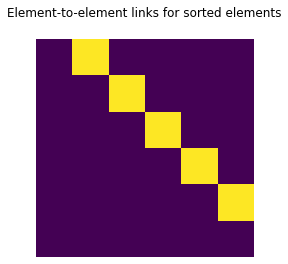

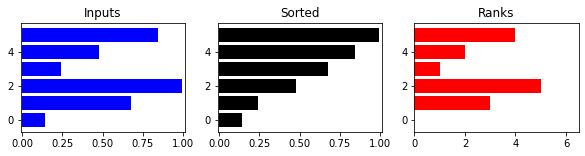

In [142]:
num_elements_min_max = (5, 10)

inputs, targets, sort_indices, ranks = create_data(
    1, num_elements_min_max)

inputs_nodes = inputs.nodes.numpy()
targets = utils_tf.nest_to_numpy(targets)
sort_indices_nodes = sort_indices.nodes.numpy()
ranks_nodes = ranks.nodes.numpy()

sort_indices = np.squeeze(sort_indices_nodes).astype(int)## squeeze the 2d array in 1d array
print(inputs_nodes)
print(sort_indices)

# Plot sort linked lists.
# The matrix plots show each element from the sorted list (rows), and which
# element they link to as next largest (columns). Ground truth is a diagonal
# offset toward the upper-right by one.

fig = plt.figure(1, figsize=(4, 4))
fig.clf()
ax = fig.add_subplot(1, 1, 1)
plot_linked_list(ax,
                 utils_np.graphs_tuple_to_networkxs(targets)[0], sort_indices)
ax.set_title("Element-to-element links for sorted elements")
ax.set_axis_off()

fig = plt.figure(2, figsize=(10, 2))
fig.clf()
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

i = 0
num_elements = ranks_nodes.shape[0]
inputs = np.squeeze(inputs_nodes)
ranks = np.squeeze(ranks_nodes * (num_elements - 1.0)).astype(int)
x = np.arange(inputs.shape[0])

ax1.set_title("Inputs")
ax1.barh(x, inputs, color="b")
ax1.set_xlim(-0.01, 1.01)

ax2.set_title("Sorted")
ax2.barh(x, inputs[sort_indices], color="k")
ax2.set_xlim(-0.01, 1.01)

ax3.set_title("Ranks")
ax3.barh(x, ranks, color="r")
_ = ax3.set_xlim(0, len(ranks) + 0.5)